# Load Data

In [ ]:
import os
import re
import pickle
import hashlib
import zipfile
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm import tqdm
from collections import Counter
from os.path import isfile, isdir
from urllib.request import urlretrieve
from tensorflow.python.ops import math_ops
from google.colab import drive

drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/data'
encoding = "ISO-8859-1"

def _unzip(save_path, _, database_name, data_path):
    """Unzip wrapper with the same interface as _ungzip
    Args:
        save_path: The path of the gzip files
        database_name: Name of database
        data_path: Path to extract to
        _: HACK - Used to have to same interface as _ungzip
    """
    print(f'Extracting {database_name}...')
    with zipfile.ZipFile(save_path) as zf:
        zf.extractall(data_path)


def download_extract(database_name, data_path):
    """Download and extract database
    Args:
        database_name: Database name
        data_path: Path to extract to
    """
    DATASET_NAME = 'ml-1m'
    if database_name == DATASET_NAME:
        url = 'http://files.grouplens.org/datasets/movielens/ml-1m.zip'
        hash_code = 'c4d9eecfca2ab87c1945afe126590906'
        extract_path = os.path.join(data_path, DATASET_NAME)
        save_path = os.path.join(data_path, f'{DATASET_NAME}.zip')
        extract_fn = _unzip

    if os.path.exists(extract_path):
        print(f'Found {database_name} Data')
        return

    if not os.path.exists(data_path):
        os.makedirs(data_path)

    if not os.path.exists(save_path):
        with DLProgress(unit='B', unit_scale=True, miniters=1, desc=f'Downloading {database_name}') as pbar:
            urlretrieve(url, save_path, pbar.hook)

    assert hashlib.md5(open(save_path, 'rb').read()).hexdigest() == hash_code, \
        f'{save_path} file is corrupted.  Remove the file and try again.'

    os.makedirs(extract_path)
    try:
        extract_fn(save_path, extract_path, database_name, data_path)
    except Exception as err:
        shutil.rmtree(extract_path)  # Remove extraction folder if there is an error
        raise err

    print('Done downloading and extracing')


class DLProgress(tqdm):
    """Handle Progress Bar while Downloading"""
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        """
        A hook function that will be called once on establishment of the network connection and
        once after each block read thereafter.
        Args:
            block_num: A count of blocks transferred so far
            block_size: Block size in bytes
            total_size: The total size of the file. This may be -1 on older FTP servers which do not return
                            a file size in response to a retrieval request.
        """
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

users_title = ['UserID', 'Gender', 'Age', 'OccupationID', 'Zip-code']
users = pd.read_csv(data_path+'/ml-1m/users.dat', sep='::', header=None, names=users_title, engine = 'python')
users.head()

movies_title = ['MovieID', 'Title', 'Genres']
movies = pd.read_csv(data_path+'/ml-1m/movies.dat', sep='::', header=None, names=movies_title, engine = 'python', encoding="ISO-8859-1")
movies.head()

ratings_title = ['UserID','MovieID', 'Rating', 'timestamps']
ratings = pd.read_csv(data_path+'/ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')
ratings.head()

# Preprocessing
# Gender: change F to 0 and change M to 1
# Age: transform to continous numbers from 0 to 7
# Genres: transform to digits
# Title: same as Genres
# Notes: The length of Genres and Title should be same.

def load_data():
    """Load dataset from file and then preprocessing it"""
    # Load users' data
    users_title = ['UserID', 'Gender', 'Age', 'JobID', 'Zip-code']
    users = pd.read_csv(data_path+'/ml-1m/users.dat', sep='::', header=None, names=users_title, engine='python')
    users = users.filter(regex='UserID|Gender|Age|JobID')
    users_origin = users.values
    # Preprocess users' gender and age attributes
    gender_map = {'F': 0, 'M': 1}
    users['Gender'] = users['Gender'].map(gender_map)
    age_map = {val: idx for idx, val in enumerate(set(users['Age']))}
    users['Age'] = users['Age'].map(age_map)

    # Load movies' data
    movies_title = ['MovieID', 'Title', 'Genres']
    movies = pd.read_csv(data_path+'/ml-1m/movies.dat', sep='::', header=None, names=movies_title, engine='python', encoding="ISO-8859-1")
    movies_origin = movies.values
    # Remove year from title
    pattern = re.compile(r'^(.*)\((\d+)\)$')
    title_map = {title: pattern.match(title).group(1) for title in set(movies['Title'])}
    movies['Title'] = movies['Title'].map(title_map)
    # Change movies' genre to dict with numbers
    genres_set = set()
    for val in movies['Genres'].str.split('|'):
        genres_set.update(val)
    genres_set.add('<PAD>')
    genres2int = {val: idx for idx, val in enumerate(genres_set)}
    genres_map = {val: [genres2int[row] for row in val.split('|')] for val in set(movies['Genres'])}
    for key in genres_map:
        for cnt in range(max(genres2int.values()) - len(genres_map[key])):
            genres_map[key].insert(len(genres_map[key]) + cnt, genres2int['<PAD>'])
    movies['Genres'] = movies['Genres'].map(genres_map)

    # Change movies' title to dict with numbers
    title_set = set()
    for val in movies['Title'].str.split():
        title_set.update(val)
    title_set.add('<PAD>')
    title2int = {val: idx for idx, val in enumerate(title_set)}
    title_count = 15
    title_map = {val: [title2int[row] for row in val.split()] for val in set(movies['Title'])}
    for key in title_map:
        for cnt in range(title_count - len(title_map[key])):
            title_map[key].insert(len(title_map[key]) + cnt, title2int['<PAD>'])
    movies['Title'] = movies['Title'].map(title_map)

    # Load ratings' data
    ratings_title = ['UserID', 'MovieID', 'ratings', 'timestamps']
    ratings = pd.read_csv(data_path+'/ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine='python')
    ratings = ratings.filter(regex='UserID|MovieID|ratings')

    # Merge
    data = pd.merge(pd.merge(ratings, users), movies)

    # Split data into two parts
    target_fields = ['ratings']
    features_pd, targets_pd = data.drop(target_fields, axis=1), data[target_fields]
    features = features_pd.values
    targets_values = targets_pd.values

    return title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_origin, users_origin

title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_origin, users_origin = load_data()
pickle.dump((title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_origin, users_origin), open(data_path+'/preprocess_movies.pkl', 'wb'))



Mounted at /content/drive


In [ ]:
data_path

'/content/drive/MyDrive/data'

In [ ]:
# download_extract('ml-1m', data_path)

In [ ]:
data

,UserID,MovieID,ratings,Gender,Age,JobID,Title,Genres
0,1,1193,5,0,0,10,"[1152, 3132, 3543, 2089, 319, 3265, 4854, 4854...","[12, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,..."
1,2,1193,5,1,5,16,"[1152, 3132, 3543, 2089, 319, 3265, 4854, 4854...","[12, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,..."
2,12,1193,4,1,6,12,"[1152, 3132, 3543, 2089, 319, 3265, 4854, 4854...","[12, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,..."
3,15,1193,4,1,6,7,"[1152, 3132, 3543, 2089, 319, 3265, 4854, 4854...","[12, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,..."
4,17,1193,5,1,3,1,"[1152, 3132, 3543, 2089, 319, 3265, 4854, 4854...","[12, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,..."
...,...,...,...,...,...,...,...,...
1000204,5949,2198,5,1,4,17,"[2104, 4854, 4854, 4854, 4854, 4854, 4854, 485...","[7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ..."
1000205,5675,2703,3,1,1,14,"[4561, 1601, 4854, 4854, 4854, 4854, 4854, 485...","[12, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,..."
1000206,5780,2845,1,1,4,17,"[1702, 2292, 4854, 4854, 4854, 4854, 4854, 485...","[12, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,..."
1000207,5851,3607,5,0,4,20,"[1152, 3919, 2450, 4854, 4854, 4854, 4854, 485...","[4, 12, 10, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6..."


[[1 1193 0 ... 10
  list([1152, 3132, 3543, 2089, 319, 3265, 4854, 4854, 4854, 4854, 4854, 4854, 4854, 4854, 4854])
  list([12, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6])]
 [2 1193 1 ... 16
  list([1152, 3132, 3543, 2089, 319, 3265, 4854, 4854, 4854, 4854, 4854, 4854, 4854, 4854, 4854])
  list([12, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6])]
 [12 1193 1 ... 12
  list([1152, 3132, 3543, 2089, 319, 3265, 4854, 4854, 4854, 4854, 4854, 4854, 4854, 4854, 4854])
  list([12, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6])]
 ...
 [5780 2845 1 ... 17
  list([1702, 2292, 4854, 4854, 4854, 4854, 4854, 4854, 4854, 4854, 4854, 4854, 4854, 4854, 4854])
  list([12, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6])]
 [5851 3607 0 ... 20
  list([1152, 3919, 2450, 4854, 4854, 4854, 4854, 4854, 4854, 4854, 4854, 4854, 4854, 4854, 4854])
  list([4, 12, 10, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6])]
 [5938 2909 1 ... 1
  list([3289, 4324, 399, 5202, 2947, 1181, 4854, 4854, 4854,

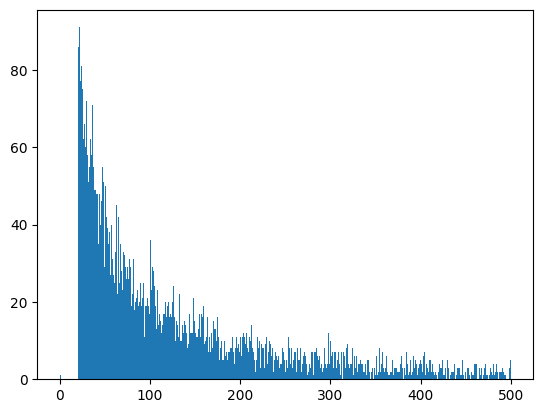

(1589,)


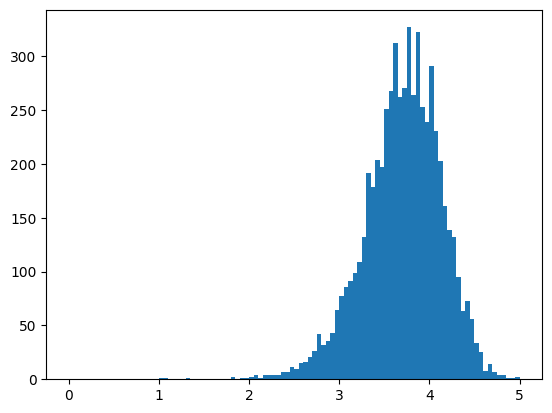

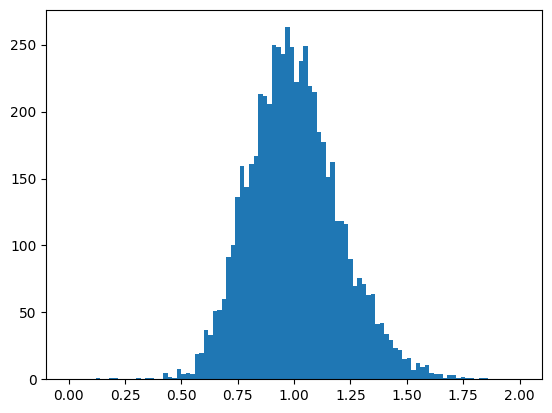

[   0    1    2 ... 5658 5659 5660]


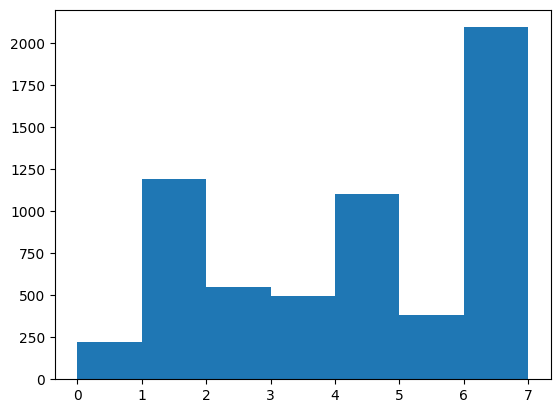

(array([711., 528., 267., 173., 759., 112., 236., 679.,  17.,  92., 195.,
        129., 388., 142., 302., 144., 241., 502.,  70.,  72., 281.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21.]),
 <BarContainer object of 21 artists>)

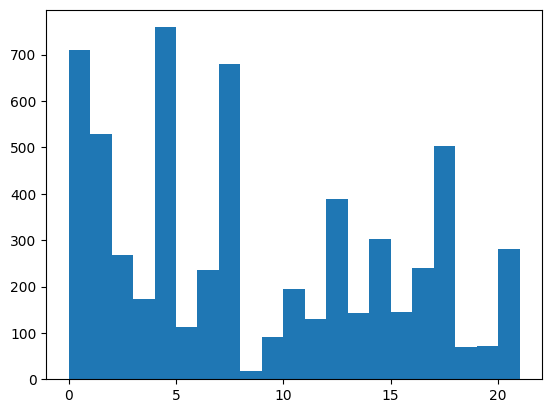

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_origin, users_origin = pickle.load(open(data_path+'/preprocess_movies.pkl', 'rb'))

print(features) # features: user id, movie id, gender, age, job, title, genre
print(ratings) # ratings: user_id, movie_id, rating

# suppose we want to extract the occurrences of each user:

user_occur = features[:, 0].astype(dtype='int64')
user_occur = np.bincount(user_occur)
plt.hist(user_occur, 500, range=[0, 500]) # turns out the inactive users are already removed from the dataset
plt.show()
inactive_user = np.where(user_occur <= 200)[0]-1
print(inactive_user.shape)
inactive_user = np.random.choice(inactive_user, 1000)
print(inactive_user.shape)
# print("=========")
# print(active_user) # in this way we have the index for users who have more than 200 ratings

# suppose we want to see the average rating of each user:

# print(ratings)
user_rating = np.array(ratings[["UserID", "ratings"]]).T.astype(int)
# print(user_rating)
mean_by_users = []
std_by_users = []
for i in range(1,6041):
    rating_distribution = (user_rating[1][np.where(user_rating[0] == i)])
    mean_by_users.append(np.mean(rating_distribution))
    std_by_users.append(np.std(rating_distribution))

plt.hist(mean_by_users, 100, range=[0, 5])
plt.show()
plt.hist(std_by_users, 100, range=[0, 2])
plt.show()
mean_by_users = np.array(mean_by_users)
std_by_users = np.array(std_by_users)
mean_by_users = mean_by_users[np.where((mean_by_users > 3.0))] # if the user is constantly giving too low or too high ratings, they are probably not of very good quality
filter_by_mean = np.where((mean_by_users < 4.5))[0]
filter_by_std = np.where((std_by_users < 1.0))[0]
print(filter_by_mean)
pickle.dump((inactive_user, filter_by_mean, filter_by_std), open(data_path+'/user_filters.pkl', 'wb'))

# print(users[["UserID", "Age"]])
plt.hist(users["Age"], 7, range=[0,7])
plt.show()
plt.clf()
plt.hist(users["JobID"], 21, range=[0,21])

In [ ]:
# print(features)
all_movie = features[:, 1].astype(dtype='int64')
# print(all_movie)
# print(np.unique(all_movie))
print(movies)
np_movies = movies["MovieID"].to_numpy()
movie_occ = []
for ele in np_movies:
    movie_occ.append(np.count_nonzero(all_movie == ele))
    # print(ele, np.count_nonzero(all_movie == ele))
p = np.array(movie_occ).argsort()
print(p)
# print(max(p))
# print(movie_occ[2789])
# print(np_movies[2789])
movie_order = np.flip(np_movies[p])
# print(movie_order)

pickle.dump(np.flip(p), open(data_path+'/movie_occur_sorted.pkl', 'wb'))

      MovieID                                              Title  \
0           1  [750, 1881, 4854, 4854, 4854, 4854, 4854, 4854...   
1           2  [1734, 4854, 4854, 4854, 4854, 4854, 4854, 485...   
2           3  [1979, 2435, 301, 4854, 4854, 4854, 4854, 4854...   
3           4  [2388, 4190, 185, 4854, 4854, 4854, 4854, 4854...   
4           5  [1207, 2055, 2089, 4674, 1477, 3493, 4854, 485...   
...       ...                                                ...   
3878     3948  [3525, 2089, 2158, 4854, 4854, 4854, 4854, 485...   
3879     3949  [4024, 4802, 2914, 3459, 4854, 4854, 4854, 485...   
3880     3950  [3474, 4854, 4854, 4854, 4854, 4854, 4854, 485...   
3881     3951  [961, 2116, 2504, 4854, 4854, 4854, 4854, 4854...   
3882     3952  [1566, 2010, 4854, 4854, 4854, 4854, 4854, 485...   

                                                 Genres  
0     [1, 8, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...  
1     [15, 8, 13, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6...  
2     [4,

In [ ]:
movies[["MovieID", "Genres"]].to_numpy()

array([[1, list([1, 8, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6])],
       [2,
        list([15, 8, 13, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6])],
       [3, list([4, 17, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6])],
       ...,
       [3950,
        list([12, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6])],
       [3951,
        list([12, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6])],
       [3952,
        list([12, 14, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6])]],
      dtype=object)

In [ ]:
genre = movies["Genres"].to_numpy()
unique, count = np.unique(genre, return_counts= True)
genre_int = []
for movie in genre:
  for i in range(len(unique)):
    if movie == unique[i]:
      genre_int.append(i)
      break
    # print(unique[i], count[i])
movie_name = movies["MovieID"].to_numpy()
movie_genre = np.array(genre_int)
movie_info = np.stack([movie_name, movie_genre])
pickle.dump(movie_info, open(data_path+'/movie_info.pkl', 'wb'))

# unique = (np.unique(genre).shape)
# for ele in unique:
#     print(np.where(genre == ele))

# Train Model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 movie_titles (InputLayer)   [(None, 15)]                 0         []                            
                                                                                                  
 movie_title_embed_layer (E  (None, 15, 32)               166944    ['movie_titles[0][0]']        
 mbedding)                                                                                        
                                                                                                  
 reshape (Reshape)           (None, 15, 32, 1)            0         ['movie_title_embed_layer[0][0
                                                                    ]']                           
                                                                                              

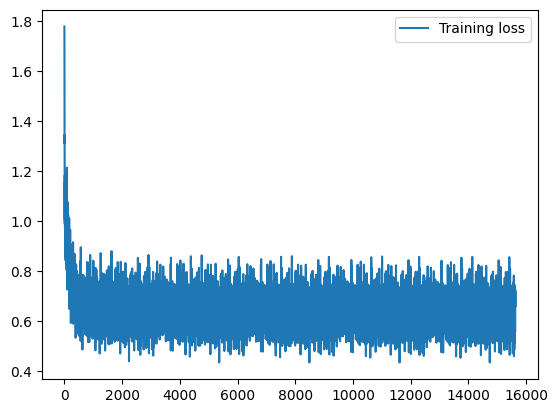

In [ ]:
import os
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import argparse

EMB_DIM = 32
NUM_EPOCH = 5


def save_params(params):
    """Save parameters to file"""
    pickle.dump(params, open('params.pkl', 'wb'))


def load_params():
    """Load parameters from file"""
    return pickle.load(open('params.pkl', 'rb'))


def get_inputs():
    uid = tf.keras.layers.Input(shape=(1,), dtype='int32', name='uid')
    user_gender = tf.keras.layers.Input(shape=(1,), dtype='int32', name='user_gender')
    user_age = tf.keras.layers.Input(shape=(1,), dtype='int32', name='user_age')
    user_job = tf.keras.layers.Input(shape=(1,), dtype='int32', name='user_job')
    movie_id = tf.keras.layers.Input(shape=(1,), dtype='int32', name='movie_id')
    movie_categories = tf.keras.layers.Input(shape=(18,), dtype='int32', name='movie_categories')
    movie_titles = tf.keras.layers.Input(shape=(15,), dtype='int32', name='movie_titles')
    return uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles


def get_user_embedding(uid, user_gender, user_age, user_job, embed_dim, uid_max, gender_max, age_max, job_max):
    uid_embed_layer = tf.keras.layers.Embedding(uid_max, embed_dim, input_length=1, name='uid_embed_layer')(uid)
    gender_embed_layer = tf.keras.layers.Embedding(gender_max, embed_dim // 2, input_length=1,
                                                   name='gender_embed_layer')(user_gender)
    age_embed_layer = tf.keras.layers.Embedding(age_max, embed_dim // 2, input_length=1, name='age_embed_layer')(
        user_age)
    job_embed_layer = tf.keras.layers.Embedding(job_max, embed_dim // 2, input_length=1, name='job_embed_layer')(
        user_job)
    return uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer


def get_user_feature_layer(uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer, embed_dim):
    # First FCL
    uid_fc_layer = tf.keras.layers.Dense(embed_dim, name="uid_fc_layer", activation='relu')(uid_embed_layer)
    gender_fc_layer = tf.keras.layers.Dense(embed_dim, name="gender_fc_layer", activation='relu')(gender_embed_layer)
    age_fc_layer = tf.keras.layers.Dense(embed_dim, name="age_fc_layer", activation='relu')(age_embed_layer)
    job_fc_layer = tf.keras.layers.Dense(embed_dim, name="job_fc_layer", activation='relu')(job_embed_layer)

    # Second FCL
    user_combine_layer = tf.keras.layers.concatenate([uid_fc_layer, gender_fc_layer, age_fc_layer, job_fc_layer],
                                                     2)  # (?, 1, 128)
    user_combine_layer = tf.keras.layers.Dense(embed_dim, activation='tanh')(user_combine_layer)  # (?, 1, 200)

    user_combine_layer_flat1 = tf.keras.layers.Reshape([embed_dim], name="user_combine_layer_flat")(user_combine_layer)

    # user_combine_layer_flat = tf.keras.layers.Lambda(lambda layer: tf.keras.utils.normalize(layer, axis=1))(user_combine_layer_flat)
    user_combine_layer_flat = call_l2_norm(user_combine_layer_flat1)

    user_combine_layer_flat_norm = tf.keras.layers.Lambda(lambda x: x, name="user_combine_layer_flat_norm")(user_combine_layer_flat)

    return user_combine_layer, user_combine_layer_flat_norm


def get_movie_id_embed_layer(movie_id, movie_id_max, embed_dim):
    movie_id_embed_layer = tf.keras.layers.Embedding(movie_id_max, embed_dim, input_length=1,
                                                     name='movie_id_embed_layer')(movie_id)
    return movie_id_embed_layer


def get_movie_categories_layers(movie_categories, movie_categories_max, embed_dim):
    movie_categories_embed_layer = tf.keras.layers.Embedding(movie_categories_max, embed_dim, input_length=18,
                                                             name='movie_categories_embed_layer')(movie_categories)
    movie_categories_embed_layer = tf.keras.layers.Lambda(lambda layer: tf.reduce_sum(layer, axis=1, keepdims=True))(
        movie_categories_embed_layer)
    return movie_categories_embed_layer


def get_movie_cnn_layer(movie_titles, movie_title_max, embed_dim, window_sizes, filter_num, sentences_size,
                        dropout_keep):
    movie_title_embed_layer = tf.keras.layers.Embedding(movie_title_max, embed_dim, input_length=15,
                                                        name='movie_title_embed_layer')(movie_titles)
    sp = movie_title_embed_layer.shape
    movie_title_embed_layer_expand = tf.keras.layers.Reshape([sp[1], sp[2], 1])(movie_title_embed_layer)
    pool_layer_lst = []
    for window_size in window_sizes:
        conv_layer = tf.keras.layers.Conv2D(filter_num, (window_size, embed_dim), 1, activation='relu')(
            movie_title_embed_layer_expand)
        maxpool_layer = tf.keras.layers.MaxPooling2D(pool_size=(sentences_size - window_size + 1, 1), strides=1)(
            conv_layer)
        pool_layer_lst.append(maxpool_layer)
    pool_layer = tf.keras.layers.concatenate(pool_layer_lst, 3, name="pool_layer")
    max_num = len(window_sizes) * filter_num
    pool_layer_flat = tf.keras.layers.Reshape([1, max_num], name="pool_layer_flat")(pool_layer)

    dropout_layer = tf.keras.layers.Dropout(dropout_keep, name="dropout_layer")(pool_layer_flat)
    return pool_layer_flat, dropout_layer


def get_movie_feature_layer(movie_id_embed_layer, movie_categories_embed_layer, dropout_layer, embed_dim):
    # First FCL 64
    movie_id_fc_layer = tf.keras.layers.Dense(embed_dim, name="movie_id_fc_layer", activation='relu')(
        movie_id_embed_layer)
    movie_categories_fc_layer = tf.keras.layers.Dense(embed_dim, name="movie_categories_fc_layer", activation='relu')(
        movie_categories_embed_layer)

    # Second FCL 200
    movie_combine_layer = tf.keras.layers.concatenate([movie_id_fc_layer, movie_categories_fc_layer, dropout_layer], 2)
    movie_combine_layer = tf.keras.layers.Dense(embed_dim, activation='tanh')(movie_combine_layer)

    movie_combine_layer_flat1 = tf.keras.layers.Reshape([embed_dim], name="movie_combine_layer_flat")(
        movie_combine_layer)

    # movie_combine_layer_flat = tf.keras.layers.Lambda(lambda layer: tf.keras.utils.normalize(layer, axis=1))(movie_combine_layer_flat)
    movie_combine_layer_flat = call_l2_norm(movie_combine_layer_flat1)

    movie_combine_layer_flat_norm = tf.keras.layers.Lambda(lambda x: x, name="movie_combine_layer_flat_norm")(movie_combine_layer_flat)

    return movie_combine_layer, movie_combine_layer_flat_norm

def call_l2_norm(inputs):
    # 计算 L2 范数
    l2_norm = tf.norm(inputs, axis=-1, keepdims=True)
    # 进行 L2 归一化
    normalized = tf.divide(inputs, l2_norm)
    return normalized

class mrs_network():
    def __init__(self, features, genres2int, title_set, title_count, embed_dim=128, batch_size=256,
                 learning_rate=0.0001, MODEL_DIR="./models128", MODEL_TYPE='non-linear'):
        self.MODEL_DIR = MODEL_DIR
        self.MODEL_TYPE = MODEL_TYPE
        # Dimension of matrix
        embed_dim = embed_dim
        # Number of users' ids
        uid_max = max(features.take(0, 1)) + 1  # 6040
        # Number of genders
        gender_max = max(features.take(2, 1)) + 1  # 1 + 1 = 2
        # Number of ages
        age_max = max(features.take(3, 1)) + 1  # 6 + 1 = 7
        # Number of jobs
        job_max = max(features.take(4, 1)) + 1  # 20 + 1 = 21

        # Number of movies
        movie_id_max = max(features.take(1, 1)) + 1  # 3952
        # Number of genres
        movie_categories_max = max(genres2int.values()) + 1  # 18 + 1 = 19
        # Number of words of movies' names
        movie_title_max = len(title_set)  # 5216

        combiner = "sum"

        # Length of movies' name
        self.sentences_size = title_count  # = 15

        window_sizes = {2, 3, 4, 5}
        filter_num = 8

        # Number of Epochs
        num_epochs = 5
        # Batch Size
        batch_size = 256

        dropout_keep = 0.5
        # Learning Rate
        learning_rate = learning_rate
        # Show stats for every n number of batches
        show_every_n_batches = 20
        self.batch_size = batch_size
        self.best_loss = 1e6
        self.losses = {'train': [], 'test': []}

        # User's input
        uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles = get_inputs()

        # User's embedding layers
        uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer = get_user_embedding(uid,
                                                                                                   user_gender,
                                                                                                   user_age,
                                                                                                   user_job,
                                                                                                   embed_dim=embed_dim,
                                                                                                   uid_max=uid_max,
                                                                                                   gender_max=gender_max,
                                                                                                   age_max=age_max,
                                                                                                   job_max=job_max)
        # User's feature
        user_combine_layer, user_combine_layer_flat = get_user_feature_layer(uid_embed_layer,
                                                                             gender_embed_layer,
                                                                             age_embed_layer,
                                                                             job_embed_layer,
                                                                             embed_dim=embed_dim)

        # Movie's id embedding layer
        movie_id_embed_layer = get_movie_id_embed_layer(movie_id, movie_id_max=movie_id_max, embed_dim=embed_dim)
        # Movie's genre embedding layer
        movie_categories_embed_layer = get_movie_categories_layers(movie_categories,
                                                                   movie_categories_max=movie_categories_max,
                                                                   embed_dim=embed_dim)
        # Movie's name layer
        pool_layer_flat, dropout_layer = get_movie_cnn_layer(movie_titles, movie_title_max=movie_title_max,
                                                             embed_dim=embed_dim,
                                                             window_sizes=window_sizes,
                                                             filter_num=filter_num, sentences_size=self.sentences_size,
                                                             dropout_keep=dropout_keep)
        # Movie's feature
        movie_combine_layer, movie_combine_layer_flat = get_movie_feature_layer(movie_id_embed_layer,
                                                                                movie_categories_embed_layer,
                                                                                dropout_layer, embed_dim=embed_dim)
        # Combine user's feature and movie's feature to get rating prediction

        if MODEL_TYPE != 'linear':
            dot_layer = tf.keras.layers.Lambda(lambda layer: layer[0] * layer[1], name="inference")(
                (user_combine_layer_flat, movie_combine_layer_flat))

            final_combine_layer1 = tf.keras.layers.concatenate(
                [user_combine_layer_flat, movie_combine_layer_flat, dot_layer],
                axis=1)  # (?, 128)
            final_combine_layer2 = tf.keras.layers.Dense(20, activation='relu')(final_combine_layer1)  # (?, 20)

            inference = tf.keras.layers.Dense(1, activation='relu')(final_combine_layer2)
        else:
            inference = tf.keras.layers.Lambda(lambda layer:
                                               (tf.reduce_sum( layer[0] * layer[1] , axis=1) + 1 ) * 2.5, name="inference")(
                (user_combine_layer_flat, movie_combine_layer_flat))
            inference = tf.keras.layers.Lambda(lambda layer: tf.expand_dims(layer, axis=1))(inference)

        self.model = tf.keras.Model(
            inputs=[uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles],
            outputs=[inference])

        # self.shallow_model = tf.keras.Model(
        #     inputs=[user_combine_layer_flat, movie_combine_layer_flat],
        #     outputs=[inference]
        # )

        self.model.summary()
        learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=1e-4,
            decay_steps=10000,
            decay_rate=0.9)
        self.optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
        # MSE Loss
        self.ComputeLoss = tf.keras.losses.MeanSquaredError()
        self.ComputeMetrics = tf.keras.metrics.MeanAbsoluteError()

        if tf.io.gfile.exists(self.MODEL_DIR):
            pass
        else:
            tf.io.gfile.makedirs(self.MODEL_DIR)

        train_dir = os.path.join(self.MODEL_DIR, 'summaries', 'train')
        test_dir = os.path.join(self.MODEL_DIR, 'summaries', 'eval')

        checkpoint_dir = os.path.join(self.MODEL_DIR, 'checkpoints')
        self.checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
        self.checkpoint = tf.train.Checkpoint(model=self.model, optimizer=self.optimizer)

        # Restore variables on creation if a checkpoint exists.
        self.checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

    def compute_loss(self, labels, logits):
        return tf.reduce_mean(tf.keras.losses.mse(labels, logits))

    def compute_metrics(self, labels, logits):
        return tf.keras.metrics.mae(labels, logits)

    @tf.function
    def train_step(self, x, y):
        with tf.GradientTape() as tape:
            logits = self.model([x[0],
                                 x[1],
                                 x[2],
                                 x[3],
                                 x[4],
                                 x[5],
                                 x[6]], training=True)
            loss = self.ComputeLoss(y, logits) # MSE
            self.ComputeMetrics(y, logits)
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss, logits

    def training(self, features, targets_values, epochs=5, log_freq=50):
        for epoch_i in range(epochs):
            # separate the dataset into training and testing
            train_X, test_X, train_y, test_y = train_test_split(features,
                                                                targets_values,
                                                                test_size=0.2,
                                                                random_state=0)

            train_batches = get_batches(train_X, train_y, self.batch_size)
            batch_num = (len(train_X) // self.batch_size)
            train_start = time.time()

            if True:
                start = time.time()
                avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)

                for batch_i in range(batch_num):
                    x, y = next(train_batches)
                    categories = np.zeros([self.batch_size, 18])
                    for i in range(self.batch_size):
                        categories[i] = x.take(6, 1)[i]

                    titles = np.zeros([self.batch_size, self.sentences_size])
                    for i in range(self.batch_size):
                        titles[i] = x.take(5, 1)[i]

                    loss, logits = self.train_step([np.reshape(x.take(0, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(2, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(3, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(4, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(1, 1), [self.batch_size, 1]).astype(np.float32),
                                                    categories.astype(np.float32),
                                                    titles.astype(np.float32)],
                                                   np.reshape(y, [self.batch_size, 1]).astype(np.float32))
                    avg_loss(loss)
                    self.losses['train'].append(loss)

                    if tf.equal(self.optimizer.iterations % log_freq, 0):
                        rate = log_freq / (time.time() - start)
                        print('Step #{}\tEpoch {:>3} Batch {:>4}/{}   Loss: {:0.6f} mae: {:0.6f} ({} steps/sec)'.format(
                            self.optimizer.iterations.numpy(),
                            epoch_i,
                            batch_i,
                            batch_num,
                            loss, (self.ComputeMetrics.result()), rate))
                        avg_loss.reset_states()
                        self.ComputeMetrics.reset_states()
                        start = time.time()

            train_end = time.time()
            print('\nTrain time for epoch #{} ({} total steps): {}'.format(epoch_i + 1,
                                                                           self.optimizer.iterations.numpy(),
                                                                           train_end - train_start))
            self.testing((test_X, test_y), self.optimizer.iterations)
        self.export_path = os.path.join(self.MODEL_DIR, 'export')
        tf.saved_model.save(self.model, self.export_path)

    def testing(self, test_dataset, step_num):
        test_X, test_y = test_dataset
        test_batches = get_batches(test_X, test_y, self.batch_size)

        avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)

        batch_num = (len(test_X) // self.batch_size)
        for batch_i in range(batch_num):
            x, y = next(test_batches)
            categories = np.zeros([self.batch_size, 18])
            for i in range(self.batch_size):
                categories[i] = x.take(6, 1)[i]

            titles = np.zeros([self.batch_size, self.sentences_size])
            for i in range(self.batch_size):
                titles[i] = x.take(5, 1)[i]

            logits = self.model([np.reshape(x.take(0, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(2, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(3, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(4, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(1, 1), [self.batch_size, 1]).astype(np.float32),
                                 categories.astype(np.float32),
                                 titles.astype(np.float32)], training=False)
            test_loss = self.ComputeLoss(np.reshape(y, [self.batch_size, 1]).astype(np.float32), logits)
            avg_loss(test_loss)
            # Save testing loss
            self.losses['test'].append(test_loss)
            self.ComputeMetrics(np.reshape(y, [self.batch_size, 1]).astype(np.float32), logits)

        print('Model test set loss: {:0.6f} mae: {:0.6f}'.format(avg_loss.result(),
                                                                 self.ComputeMetrics.result()))

        if avg_loss.result() < self.best_loss:
            self.best_loss = avg_loss.result()
            print(f'best loss = {self.best_loss}')
            self.checkpoint.save(self.checkpoint_prefix)

    def forward(self, xs):
        predictions = self.model(xs)
        return predictions

    # def forward_shallow(self, user_embedding, movie_embedding):
    #     predictions = self.shallow_model(user_embedding, movie_embedding)
    #     return predictions


def get_batches(Xs, ys, batch_size):
    for start in range(0, len(Xs), batch_size):
        end = min(start + batch_size, len(Xs))
        yield Xs[start:end], ys[start:end]



title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_origin, users_origin = pickle.load(
    open(data_path+'/preprocess_movies.pkl', 'rb'))


save_folder = data_path+"/model_norm_l2"
model_type = "linear"
# if true, training using partial data
part_train = False
# if false, construct the training set by randomly deleting #num_dummy_genres genres in each user's record
# if true, construct the training set by 5-5 split
random_split = True
num_dummy_genres = 5
if part_train:
    if not random_split:
        valid_index = []
        dummy_genres = []
        for i in range(num_dummy_genres):
            dummy_genres.append(
                np.random.choice([3, 14, 0, 1, 7, 13, 12, 9, 4, 8, 16, 11, 10, 2, 6, 15, 17, 18], 6040))
        for index, row in tqdm(data.iterrows()):
            dummy_genre = set([dummy_genres[i][row['UserID'] - 1] for i in range(num_dummy_genres)])
            if not set(row['Genres']).intersection(dummy_genre):
                valid_index.append(index)
        print('Size of training set:', len(valid_index))
        data_ = data.iloc[valid_index]
        features_pd, targets_pd = data_.drop(['ratings'], axis=1), data_[['ratings']]
        features = features_pd.values
        targets_values = targets_pd.values

        mrs_net = mrs_network(features=features
                              , genres2int=genres2int
                              , title_set=title_set
                              , title_count=title_count
                              , embed_dim=EMB_DIM
                              , MODEL_DIR=save_folder + str(EMB_DIM) + "_discard" + str(
                num_dummy_genres) + "genres_v2"
                              , MODEL_TYPE=model_type)
        mrs_net.training(features, targets_values, epochs=NUM_EPOCH)
        mrs_net.model.save_weights(
            save_folder + str(EMB_DIM) + '_discard' + str(num_dummy_genres) + 'genres_v2/weights')
        pickle.dump(set(valid_index),
                    open('used_data_index_discard' + str(num_dummy_genres) + 'genres_v2.pkl', 'wb'))
    else:
        half_idx = np.random.choice(range(len(features)), len(features) // 2, replace=False)
        half_features = features[half_idx]
        half_targets_values = targets_values[half_idx]
        mrs_net = mrs_network(features=half_features
                              , genres2int=genres2int
                              , title_set=title_set
                              , title_count=title_count
                              , embed_dim=EMB_DIM
                              , MODEL_DIR=save_folder + str(EMB_DIM)
                              , MODEL_TYPE=model_type)
        mrs_net.training(half_features, half_targets_values, epochs=NUM_EPOCH)
        pickle.dump(half_idx, open('used_data_index.pkl', 'wb'))
        mrs_net.model.save_weights(save_folder + str(EMB_DIM) + '/weights_half')
else:
    mrs_net = mrs_network(features=features
                          , genres2int=genres2int
                          , title_set=title_set
                          , title_count=title_count
                          , embed_dim=EMB_DIM
                          , MODEL_DIR=save_folder + str(EMB_DIM)
                          , MODEL_TYPE=model_type)
    mrs_net.training(features, targets_values, epochs=NUM_EPOCH)
    mrs_net.model.save_weights(save_folder + str(EMB_DIM) + '_v2' + '/weights')

plt.plot(mrs_net.losses['train'], label='Training loss')
plt.legend()
plt.show()


# Generate Embeddings

In [ ]:
import pickle
from tensorflow import keras
import numpy as np
from tqdm import tqdm
import argparse

EMB_SIZE = 32
model_dir = data_path+'/model_norm_l2'+str(EMB_SIZE)+'_v2/weights'
save_name = 'emb_norm_l2_'+str(EMB_SIZE)+'.pkl'


title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_origin, users_origin = pickle.load(open(data_path+'/preprocess_movies.pkl', 'rb'))
sentences_size = title_count
print(ratings)
# 创建模型实例
mrs_net = mrs_network(features=features, genres2int=genres2int, title_set=title_set, title_count=title_count, embed_dim=EMB_DIM)
# 恢复权重
mrs_net.model.load_weights(model_dir)

# users embeddings
user_layer_model = keras.models.Model(inputs=[mrs_net.model.input[0], mrs_net.model.input[1], mrs_net.model.input[2], mrs_net.model.input[3]],
                                outputs=mrs_net.model.get_layer("user_combine_layer_flat_norm").output)


users_emb = []
for item in tqdm(users.values):
    user_combine_layer_flat_val = user_layer_model([np.reshape(item.take(0), [1, 1]),
                                                    np.reshape(item.take(1), [1, 1]),
                                                    np.reshape(item.take(2), [1, 1]),
                                                    np.reshape(item.take(3), [1, 1])])
    users_emb.append(user_combine_layer_flat_val)

# Here we can select users based on their indices
np_user_emb = np.array(users_emb).reshape(-1, EMB_SIZE)
# np_user_emb = np_user_emb[active_user]

# We have 6040 users, and use the features table to select the users we want.

pickle.dump((np.array(users_emb).reshape(-1, EMB_SIZE)), open(data_path+'/user_'+save_name, 'wb'))

# movies embeddings
movie_layer_model = keras.models.Model(inputs=[mrs_net.model.input[4], mrs_net.model.input[5], mrs_net.model.input[6]],
                                outputs=mrs_net.model.get_layer("movie_combine_layer_flat_norm").output)

movie_emb = []

for item in tqdm(movies.values):
    categories = np.zeros([1, 18])
    categories[0] = item.take(2)

    titles = np.zeros([1, sentences_size])
    titles[0] = item.take(1)

    movie_combine_layer_flat_val = movie_layer_model([np.reshape(item.take(0), [1, 1]), categories, titles])
    movie_emb.append(movie_combine_layer_flat_val)

pickle.dump((np.array(movie_emb).reshape(-1, EMB_SIZE)), open(data_path+'/movie_'+save_name, 'wb'))

# users_emb1 = pickle.load(open('users_emb.pkl', mode='rb'))
# print(users_emb1)
# movie_emb1 = pickle.load(open('movie_emb.pkl', mode='rb'))
# print(movie_emb1)


         UserID  MovieID  ratings
0             1     1193        5
1             1      661        3
2             1      914        3
3             1     3408        4
4             1     2355        5
...         ...      ...      ...
1000204    6040     1091        1
1000205    6040     1094        5
1000206    6040      562        5
1000207    6040     1096        4
1000208    6040     1097        4

[1000209 rows x 3 columns]
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 movie_titles (InputLayer)   [(None, 15)]                 0         []                            
                                                                                                  
 movie_title_embed_layer (E  (None, 15, 32)               166944    ['movie_titles[0][0]']        
 mbedding)                                          

100%|██████████| 3883/3883 [01:18<00:00, 49.28it/s]


# T-SNE Visualization

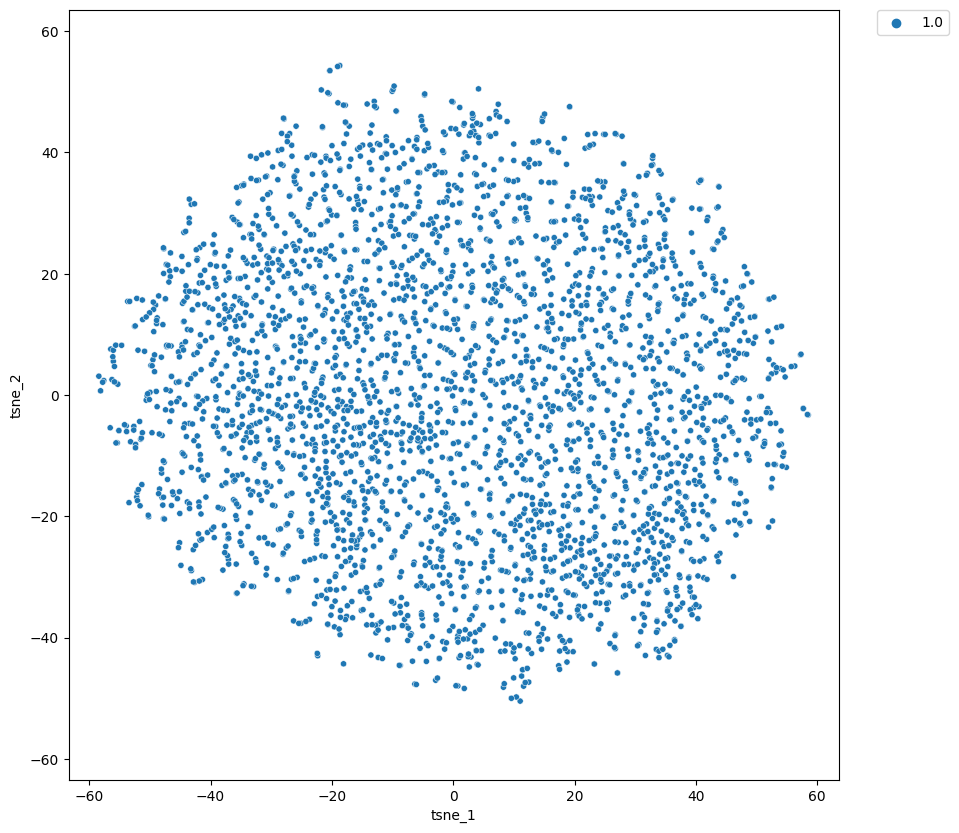

In [ ]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def get_TSNE_emb(target_emb, n_components=2):
  """get TSNE embedding with 2 dimensions"""
  tsne = TSNE(n_components)
  tsne_result = tsne.fit_transform(target_emb)
  return tsne_result

def show_TSNE(tsne_result, label):
  """Plot the result of our TSNE with the label color coded"""
  tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': label})
  fig, ax = plt.subplots(1)
  sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=20)
  lim = (tsne_result.min()-5, tsne_result.max()+5)
  fig.set_figheight(10)
  fig.set_figwidth(15)
  ax.set_xlim(lim)
  ax.set_ylim(lim)
  ax.set_aspect('equal')
  ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

#np_user_emb[filter_by_mean]
tsne_result = get_TSNE_emb(np_user_emb[filter_by_std])

# show all users
show_TSNE(tsne_result, label=np.ones_like(tsne_result[:,0]))

In [ ]:
movie = np.array(movie_emb)
np.linalg.norm(movie, axis=-1)

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [ ]:
user = np.array(users_emb)
np.linalg.norm(users_emb, axis=-1)

array([[1.        ],
       [1.        ],
       [1.        ],
       ...,
       [1.        ],
       [1.        ],
       [0.99999994]], dtype=float32)

In [ ]:
data_path+'/movie_'+save_name

'/content/drive/MyDrive/data/movie_emb_norm_l2_32.pkl'

In [ ]:
call_l2_norm(users_emb[0])

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[ 0.40185538,  0.17359626, -0.06569972, -0.20414941,  0.1846881 ,
        -0.00825452, -0.22001438, -0.12152995,  0.26055032, -0.07296523,
         0.03786055,  0.0236444 , -0.16700813,  0.18121618,  0.38071594,
        -0.15000032, -0.10421384, -0.02352415, -0.1323936 ,  0.17236558,
        -0.19286045,  0.15337533, -0.12719898, -0.17149647, -0.32577938,
        -0.1036874 ,  0.08597749,  0.1920439 ,  0.0521905 , -0.11950867,
         0.06546099,  0.11933839]], dtype=float32)>